# Setup

In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: rich_clust
python version: 3.9.12


In [2]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import natsort

import torch
# from kymatio.torch import Scattering2D

import gc
import time
import functools
import multiprocessing as mp


In [3]:
# params = {
#     'dir_github': r'/media/rich/Home_Linux_partition/github_repos/',
#     'dir_allOuterFolders': r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10",
#     'pathSuffixToStat': 'plane1/stat.npy',
#     'pathSuffixToOps': 'plane1/ops.npy',
#     'pref_use_NN_distances': True,
#     'use_GPU': True,
#     'pref_blurROIs': True,
#     'params_blur': {
#         'kernel_size': 7, # Edge length of kernel image. Make odd number.
#         'kernel_width': 2.1, # width of 1 full cosine cycle for the 2d cosine kernel. Use width=2 for a single pixel.
#     },
#     'mask_power': 1, ## This parameter determines how 'binary'-looking masks are. Small values = more binary. Large values weight bright pixels more. mask_scaled = mask**mask_power
#     'params_dIOU': {
#         'algorithm': 'brute', ## Can be 'brute', 'auto', or anything from sklearn.neighbors.NearestNeighbors
#         'n_neighbors': 'full', ## Can either be an int or 'full', in which case the output will not be sparse
#     }
# }

In [4]:
dir_github = Path(r'/media/rich/Home_Linux_partition/github_repos/').resolve()

import sys
sys.path.append(str(dir_github))

In [5]:
# device = torch_helpers.set_device(use_GPU=params['use_GPU'])

In [6]:
%load_ext autoreload
%autoreload 2
from ROICaT.tracking import data_importing, visualization, alignment, blurring, helpers, ROInet, scatteringWaveletTransformer, similarity_graph, cluster_assignment

In [7]:
%matplotlib notebook

# Import paths

In [8]:
def print_list(l):
    for item in l:
        print(item)

In [9]:
dir_allOuterFolders = Path(r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10").resolve()

folders_allSessions = natsort.natsorted(helpers.get_dir_contents(dir_allOuterFolders)[0])

dir_allS2pFolders = [dir_allOuterFolders / folder for folder in folders_allSessions]

pathSuffixToStat = 'plane1/stat.npy'
pathSuffixToOps = 'plane1/ops.npy'

paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])[:]
paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])[:]

print(f'folder names of all sessions: \n{folders_allSessions}')
print(f'paths to all stat files: \n{paths_allStat}')


folder names of all sessions: 
['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14']
paths to all stat files: 
[PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D1/plane1/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D2/plane1/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D3/plane1/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D4/plane1/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D5/plane1/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D6/plane1/stat.npy')
 PosixPath('/media/rich/bigSSD/

# Import data

In [10]:
data = data_importing.Data_suite2p(
    paths_statFiles=paths_allStat,
    paths_opsFiles=paths_allOps,
    um_per_pixel=1.0,
    verbose=True,
)

data.import_statFiles();

data.import_ROI_centeredImages(
    out_height_width=[72,72],
    max_footprint_width=1025,
);

data.import_FOV_images(
    type_meanImg='meanImgE',
    images=None
);

data.import_ROI_spatialFootprints(workers=-1);

Starting: Importing spatial footprints from stat files
Completed: Imported 14 stat files into class as self.statFiles. Total number of ROIs: 37061. Number of ROI from each file: [2451, 2798, 2656, 2865, 2349, 2926, 2527, 2055, 4600, 2735, 2740, 1915, 2286, 2158]


100%|███████████████████████████████████████████| 14/14 [00:01<00:00, 10.78it/s]


Converted 14 spatial footprint files into small centered images in self.ROI_images.
Imported 14 FOV images into class as self.FOV_images
Imported 14 sessions of spatial footprints into sparse arrays.


<IPython.core.display.Javascript object>


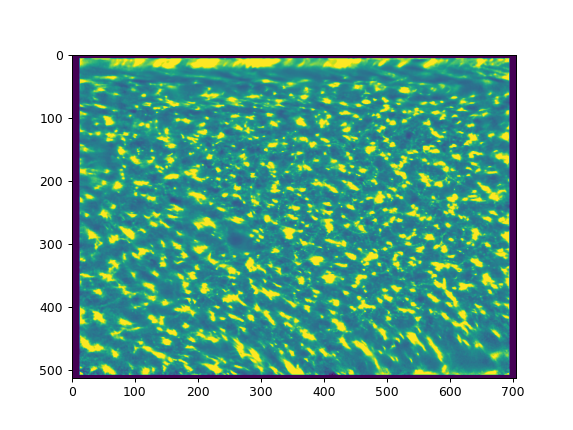

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [11]:
visualization.display_toggle_image_stack(data.FOV_images)

# Alignment

In [12]:
aligner = alignment.Alinger(
    method='createOptFlow_DeepFlow',
    kwargs_method=None
)

aligner.register_ROIs(
    templateFOV=data.FOV_images[0],
    FOVs=data.FOV_images,
    ROIs=data.spatialFootprints,
    return_sparse=True,
    normalize=True,
);

100%|███████████████████████████████████████████████████████████████████████████████| 14/14 [03:00<00:00, 12.88s/it]


<IPython.core.display.Javascript object>


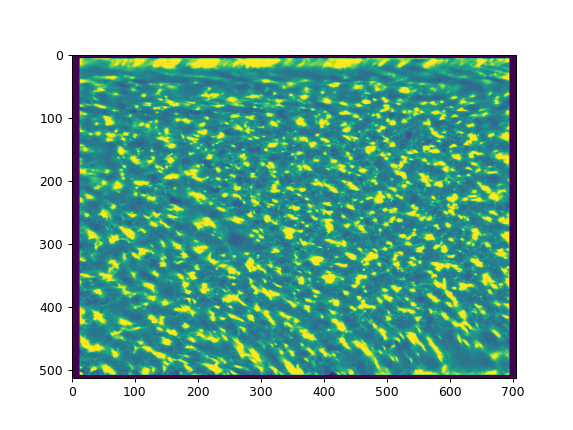

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


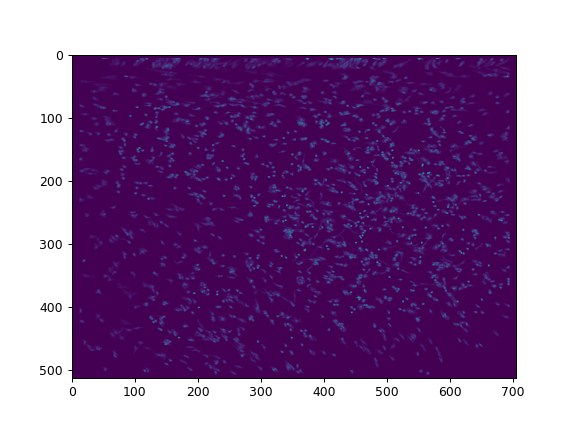

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [13]:
visualization.display_toggle_image_stack(aligner.FOVs_aligned)
visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection())

## Blur ROIs (optional)

<IPython.core.display.Javascript object>


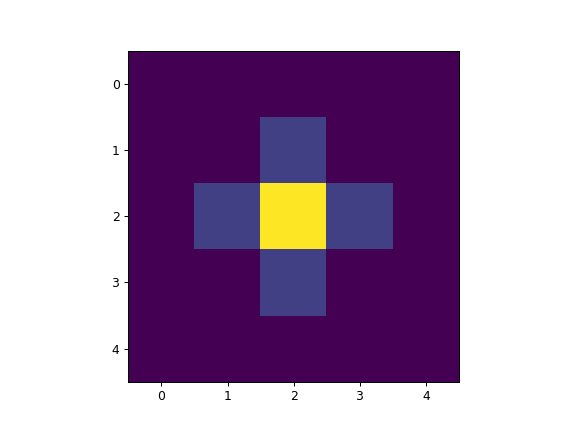

[Exception|implicit_gemm_pair]indices=torch.Size([72236, 3]),bs=2000,ss=[512, 705],algo=ConvAlgo.MaskImplicitGemm,ksize=[5, 5],stride=[1, 1],padding=[2, 2],dilation=[1, 1],subm=False,transpose=False


SPCONV_DEBUG_SAVE_PATH not found, you can specify SPCONV_DEBUG_SAVE_PATH as debug data save path to save debug data which can be attached in a issue.


AssertionError: implicit gemm only support cuda

In [14]:
blurrer = blurring.ROI_Blurrer(
    frame_shape=(data.FOV_height, data.FOV_width),
    kernel_halfWidth=1.4,
    device='cpu',
    plot_kernel=True
)

blurrer.blur_ROIs(
    spatialFootprints=aligner.ROIs_aligned,
    batch_size=2000,
);

In [ ]:
visualization.display_toggle_image_stack(blurrer.get_ROIsBlurred_maxIntensityProjection())

## Neural network embedding distances

In [ ]:
hash_dict_true = {
    'params': ('params.json', '877e17df8fa511a03bc99cd507a54403'),
    'model': ('model.py', '6ef5c29793ae16a64e43e8cab33d9ff4'),
    'state_dict': ('ConvNext_tiny__1_0_unfrozen__simCLR.pth', 'a5fae4c9ea95f2c78b4690222b2928a5'),
}

roinet = ROInet.ROInet_embedder(
    device='cuda:0',
    dir_networkFiles='/home/rich/Downloads/ROInet',
    download_from_gDrive='check_local_first',
    gDriveID='1FCcPZUuOR7xG-hdO6Ei6mx8YnKysVsa8',
    hash_dict_networkFiles=hash_dict_true,
    verbose=True,
)

roinet.generate_dataloader(
    ROI_images=data.ROI_images,
#     goal_frac=0.05,
    um_per_pixel=data.um_per_pixel,
    ptile_norm=90,
    scale_norm=0.6,
    pref_plot=False,
    batchSize_dataloader=8,
    pinMemory_dataloader=True,
    numWorkers_dataloader=mp.cpu_count(),
    persistentWorkers_dataloader=True,
    prefetchFactor_dataloader=2,    
);

# visualization.display_toggle_image_stack(roinet.ROI_images_rs)

roinet.generate_latents();

In [ ]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

## Scattering wavelet embedding distances

In [ ]:
swt = scatteringWaveletTransformer.SWT(
    kwargs_Scattering2D={'J': 2, 'L': 8}, 
    image_shape=data.ROI_images[0].shape[1:3], 
    device='cuda:0'
)

swt.transform(ROI_images=np.concatenate(data.ROI_images, axis=0));

## Compute similarities

In [ ]:
sim = similarity_graph.ROI_graph(
    device='cpu',
    n_workers=-1,
    spatialFootprint_maskPower=0.8,
    frame_height=data.FOV_height,
    frame_width=data.FOV_width,
    block_height=50,
    block_width=50,
    overlapping_width_Multiplier=0.1,
    algorithm_nearestNeigbors_spatialFootprints='brute',
    n_neighbors_nearestNeighbors_spatialFootprints='full',
    locality=1,
    verbose=True,
)

In [ ]:
sim.visualize_blocks()

In [ ]:
sim.compute_similarity_blockwise(
    spatialFootprints=blurrer.ROIs_blurred,
    features_NN=roinet.latents,
    features_SWT=swt.latents,
    ROI_session_bool=data.sessionID_concat,
    linkage_methods=['single', 'complete', 'ward', 'average'],
    linkage_distances=helpers.bounded_logspace(0.05, 2, 50),
    min_cluster_size=2,
    max_cluster_size=None,
    batch_size_hashing=300,
);

sim.compute_cluster_similarity_graph(
        cluster_similarity_reduction_intra='mean',
        cluster_similarity_reduction_inter='max',
        cluster_silhouette_reduction_intra='mean',
        cluster_silhouette_reduction_inter='max',
        n_workers=100,
);

sim.compute_cluster_scores(
    power_clusterSize=1.3, 
    power_clusterSilhouette=1.5
);

### look at results of similarity computations

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].plot(sim.scores.cpu())
axs[0].set_xlabel('ROI #')
axs[0].set_ylabel('custom similarity score')

axs[1].plot(sim.scores.cpu())
axs[1].set_yscale('log')
axs[1].set_xlabel('ROI #')
axs[1].set_ylabel('custom similarity score')

axs[2].hist(sim.scores.cpu(), 500)
axs[2].set_yscale('log')
# axs[2].set_xscale('log')
axs[2].set_ylabel('counts')
axs[2].set_xlabel('custom similarity score');

In [ ]:
plt.figure()
plt.scatter((np.array(sim.cluster_bool.sum(1)).squeeze()), sim.scores, alpha=0.01)
plt.xlabel('n_rois_in_cluster')
plt.ylabel('custom similarity score');

# Assign optimal clusters

In [ ]:
clusterAssigner = cluster_assignment.Cluster_Assigner(
    c=sim.c_sim,
    h=sim.cluster_bool.T,
    w=sim.scores,
    device='cuda:0',
    m_init=(torch.ones(sim.c_sim.shape[0])*-5 + torch.rand(sim.c_sim.shape[0])*1).type(torch.float32),
    optimizer_partial=functools.partial(torch.optim.Adam, lr=1e-1, betas=(0.9, 0.900)),
    scheduler_partial=functools.partial(torch.optim.lr_scheduler.CyclicLR, base_lr=1e-3, max_lr=3e0, step_size_up=250, cycle_momentum=False, verbose=False),
    dmCEL_temp=1,
    dmCEL_sigSlope=2,
    dmCEL_sigCenter=0.5,
    dmCEL_penalty=1e0,
    sampleWeight_softplusKwargs={'beta': 150, 'threshold': 50},
    sampleWeight_penalty=1e3,
    fracWeighted_goalFrac=1.0,
    fracWeighted_sigSlope=2,
    fracWeighted_sigCenter=0.5,
    fracWeight_penalty=1e3,
    maskL1_penalty=4e-4,
    tol_convergence=1e-9,
    window_convergence=50,
    freqCheck_convergence=50,
    verbose=True,
)

In [ ]:
clusterAssigner.fit(
    min_iter=1e3,
    max_iter=50e3,
    verbose=True, 
    verbose_interval=100
)

In [ ]:
clusterAssigner.plot_loss()

In [ ]:
gc.collect()

torch.cuda.empty_cache()

gc.collect()

torch.cuda.empty_cache()

In [ ]:
clusterAssigner.plot_clusterWeights()

clusterAssigner.plot_sampleWeights()

clusterAssigner.plot_clusterScores(bins=200)
plt.xscale('log')
plt.yscale('log')

In [ ]:
m_threshold=0.9

preds, confidence, scores_samples, m_bool = clusterAssigner.predict(m_threshold=m_threshold)

fig, axs = clusterAssigner.plot_labelCounts()
axs[0].set_ylim([0,20])

print(f'Number of clusters: {m_bool.sum()}')

# Visualize results

In [ ]:
FOV_clusters = visualization.compute_colored_FOV(
    spatialFootprints=aligner.ROIs_aligned,
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    preds=clusterAssigner.preds,
    confidence=clusterAssigner.confidence,
    threshold_confidence = 0.5
)

visualization.display_toggle_image_stack(FOV_clusters)

# Save results

In [449]:
dir_save = Path('/home/rich/Desktop/').resolve()
name_save = dir_allOuterFolders.name

In [450]:
preds_bySession = [preds[idx].numpy() for idx in data.sessionID_concat.T]

ROIs = {
    "ROIs_aligned": aligner.ROIs_aligned,
    "ROIs_raw": data.spatialFootprints,
    "frame_height": data.FOV_height,
    "frame_width": data.FOV_width,
    "idx_roi_session": [np.where(idx)[0] for idx in data.sessionID_concat.T]
}

helpers.simple_save(
    {
        "UCIDs": list(clusterAssigner.preds.numpy().astype(np.int64)),
        "UCIDs_bySession": preds_bySession,
        "ROIs": ROIs,
    },
    filename=dir_save / (name_save + '.rClust' '.pkl'),
#     filename='/media/rich/bigSSD/analysis_data/mouse 2_6/multiday_alignment/UCIDs.pkl'
)